In [1]:
import sys
sys.path.append(r'C:\PythonVenv\PaintByNumber\Lib\site-packages')
import cv2, numpy as np, matplotlib.pyplot as plt

In [72]:
def load_image(_i_path):
    return cv2.imread(_i_path)

def natural_color(_i):
    return cv2.cvtColor(_i, cv2.COLOR_BGR2RGB)

def lab_color(_i):
    return cv2.cvtColor(_i, cv2.COLOR_BGR2LAB)

def bgr_color(_i): # from rgb
    return cv2.cvtColor(_i, cv2.COLOR_RGB2BGR)

def display_image(_i):
    plt.imshow(_i)
    plt.colorbar()
    plt.show()
    
def save_image(_i, _i_path):
    cv2.imwrite(_i_path, _i)
    
def unique_colors(_im, return_counts=False):
    return np.unique(
        _im.reshape(-1, _im.shape[2]),
        axis=0,
        return_counts=return_counts
    )

def blur(_im, radius=5):
    return cv2.blur(_im, (radius, radius))

def invert(_im):
    return np.logical_not(_im)

def foreground_extractor(image, rectangle):
    #https://www.geeksforgeeks.org/python-foreground-extraction-in-an-image-using-grabcut-algorithm/
    mask = np.zeros(image.shape[:2], np.uint8)
    backgroundModel = np.zeros((1, 65), np.float64)
    foregroundModel = np.zeros((1, 65), np.float64)
    cv2.grabCut(image, mask, rectangle, 
                backgroundModel, foregroundModel,
                3, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2)|(mask == 0), 0, 1).astype('uint8')
    image = image * mask2[:, :, np.newaxis]
    return image, mask2

def buffer_mask(_mask, buffer=3):
    mask_255 = _mask * 255
    mask_255_blur = cv2.blur(mask_255, (buffer, buffer))
    mask_255_blur[mask_255_blur>0]=1
    return mask_255_blur

def smooth_mask(_m, factor):
    _m_255 = _m * 255
    _m_255_blur = cv2.blur(_m_255, (factor, factor))
    _m_255_blur[_m_255_blur*2<=255] = 0
    _m_255_blur[_m_255_blur*2>255] = 1
    return _m_255_blur

def unique_colors(_im, return_counts=False):
    return np.unique(
        _im.reshape(-1, _im.shape[2]),
        axis=0,
        return_counts=return_counts
    )

def blur(_im, radius=5):
    return cv2.blur(_im, (radius, radius))

def invert(_im):
    return np.logical_not(_im)

def mask_image(_img, _mask):
    return _mask[:, :, np.newaxis]*_img

def mask_or(mask1, mask2):
    return np.maximum(mask1, mask2)

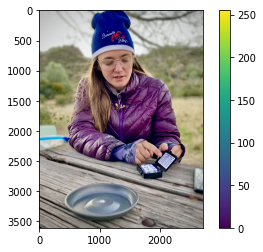

In [3]:
orig = load_image("_meagan\orig.png")
display_image(natural_color(orig))

In [ ]:
img_meg, mask_meg = foreground_extractor(image=orig, rectangle=(500, 0, 2500, 2200))
# not performing well so i'm just going to foreground extract a "stagelight" - filtered version, using apple's stuff

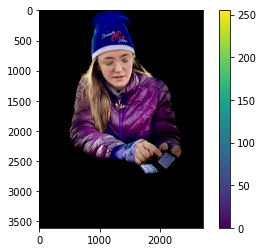

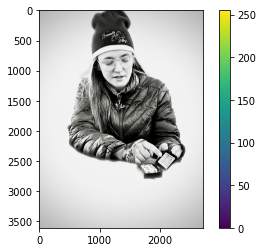

In [68]:
stagelight_color = load_image("_meagan\stagelight_color.png")
stagelight_gray = load_image("_meagan\stagelight_gray.png")
display_image(natural_color(stagelight_color))
display_image(natural_color(stagelight_gray))

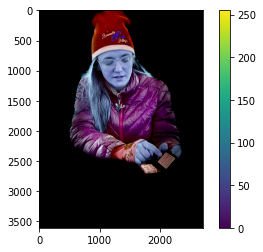

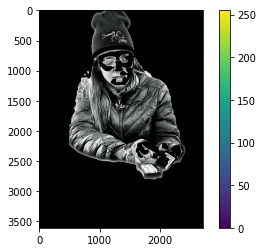

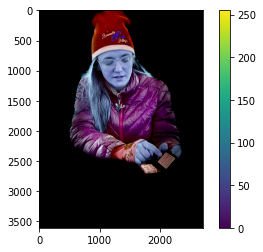

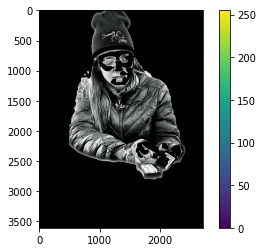

In [69]:
img_meg_stage_color, mask_meg_stage_color = foreground_extractor(image=stagelight_color, rectangle=(500, 0, 2500, 2800))
img_meg_stage_gray, mask_meg_stage_gray = foreground_extractor(image=stagelight_gray, rectangle=(500, 0, 2500, 2800))
display_image(img_meg_stage_color)
display_image(img_meg_stage_gray)

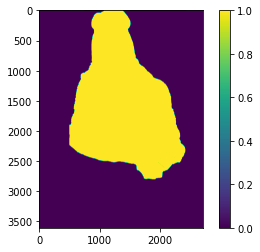

In [73]:
mask_meg_stage = mask_or(mask_meg_stage_color, mask_meg_stage_gray)
display_image(mask_meg_stage)

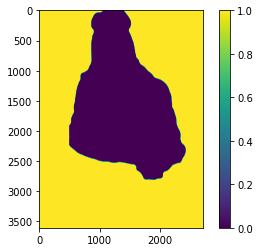

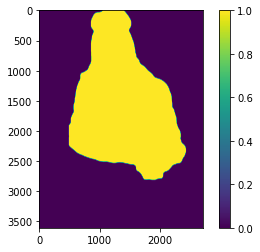

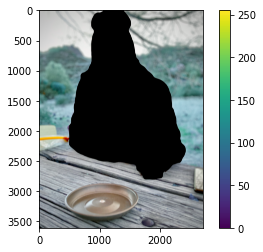

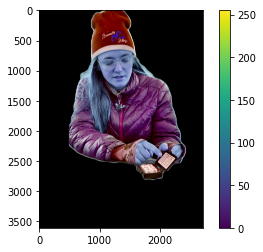

In [84]:
# gets rid of sliver at the top
mask_meg_stage_invert = invert(mask_meg_stage)
mask_meg_stage_invert_buff = buffer_mask(mask_meg_stage_invert, 20)
mask_meg_stage_reverse_invert = buffer_mask(invert(mask_meg_stage_invert_buff), 20)

# smooths the mask
mask_meg_stage_buff = buffer_mask(mask_meg_stage_reverse_invert, 20)
mask_meg_stage_buff_blur = cv2.blur(mask_meg_stage_buff, (40, 40))
mask_meg_stage_buff_blur_invert = invert(mask_meg_stage_buff_blur)
mask_meg_stage_buff_blur_invert[mask_meg_stage_buff_blur_invert*255*2<=255]=0
mask_meg_stage_buff_blur_invert[mask_meg_stage_buff_blur_invert*255*2>255]=1

# foreground should overlap background slightly - that way we avoid slivers
background_mask = buffer_mask(mask_meg_stage_buff_blur_invert, 10)
foreground_mask = buffer_mask(invert(mask_meg_stage_buff_blur_invert), 1)

# apply each mask to the original image
foreground = mask_image(orig, foreground_mask)
background = mask_image(orig, background_mask)

# display everything and save
display_image(background_mask)
display_image(foreground_mask)
display_image(background)
display_image(foreground)
save_image(background_mask, "background_mask.png")
save_image(foreground_mask, "foreground_mask.png")
save_image(background, "background.png")
save_image(foreground, "foreground.png")